In [1]:
# Modeling
from mesa import Agent, Model

# Analysis
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.time import RandomActivation

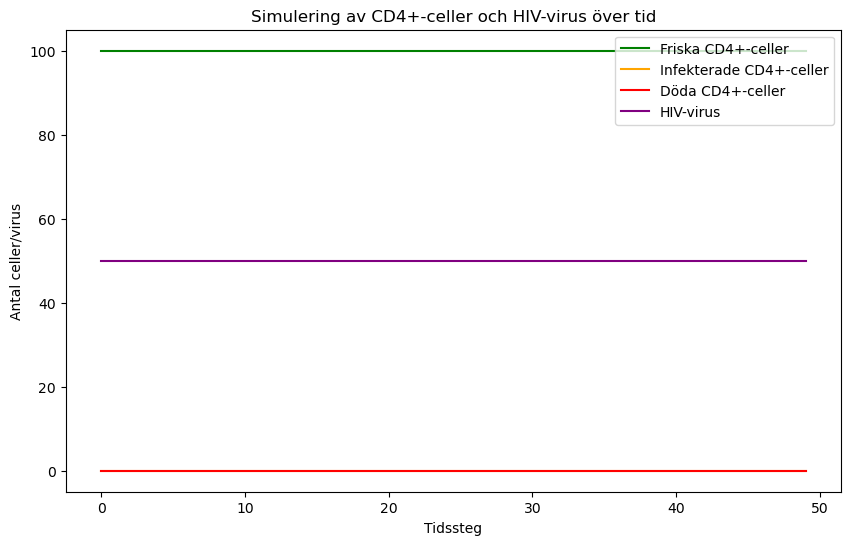

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Definiera storleken på miljön
GRID_SIZE = 580  # 580 x 580 x 580-rutnät
CELL_SIZE = 8  # Varje cell representerar 8 µm x 8 µm x 8 µm

# Skapa rutnätet (3D-matris) där None representerar en tom plats
environment = np.empty((GRID_SIZE, GRID_SIZE, GRID_SIZE), dtype=object)

# Definiera CD4+-cell och HIV-virus klasser
class CD4Cell:
    def __init__(self, x, y, z, state="Healthy"):
        self.x = x
        self.y = y
        self.z = z
        self.state = state
        self.life_time = 0  # Används om cellen blir infekterad

    def update(self):
        if self.state == "Infected":
            self.life_time += 1
            if self.life_time > 50:  # Efter en viss tid dör en infekterad cell
                self.state = "Dead"

class HIVVirus:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.life_time = 0  # Livslängd för viruset

    def decay(self):
        self.life_time += 1
        if self.life_time > 100:  # Virusets livstid, exempelvärde
            return True  # Returnerar True om viruset dör
        return False

# Initialisera miljön med CD4+-celler och HIV-virus
cd4_cells = []
hiv_viruses = []

def initialize_environment(cd4_count, hiv_count):
    for _ in range(cd4_count):
        while True:
            x, y, z = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
            if environment[x, y, z] is None:
                cd4_cell = CD4Cell(x, y, z)
                cd4_cells.append(cd4_cell)
                environment[x, y, z] = cd4_cell
                break

    for _ in range(hiv_count):
        while True:
            x, y, z = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
            if environment[x, y, z] is None:
                hiv_virus = HIVVirus(x, y, z)
                hiv_viruses.append(hiv_virus)
                environment[x, y, z] = hiv_virus
                break

# Funktion för att flytta agenter slumpmässigt
def move_agent(agent):
    dx, dy, dz = random.choice([-1, 0, 1]), random.choice([-1, 0, 1]), random.choice([-1, 0, 1])
    new_x, new_y, new_z = agent.x + dx, agent.y + dy, agent.z + dz
    new_x = max(0, min(GRID_SIZE - 1, new_x))
    new_y = max(0, min(GRID_SIZE - 1, new_y))
    new_z = max(0, min(GRID_SIZE - 1, new_z))

    if environment[new_x, new_y, new_z] is None:
        environment[agent.x, agent.y, agent.z] = None  # Rensa gamla positionen
        agent.x, agent.y, agent.z = new_x, new_y, new_z
        environment[new_x, new_y, new_z] = agent

# Funktion för interaktion mellan HIV-virus och CD4+-celler
def interact():
    for hiv in hiv_viruses:
        for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]:
            x, y, z = hiv.x + dx, hiv.y + dy, hiv.z + dz
            if 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and 0 <= z < GRID_SIZE:
                cell = environment[x, y, z]
                if isinstance(cell, CD4Cell) and cell.state == "Healthy":
                    if random.random() < 0.2:  # 20% chans att infektera cellen
                        cell.state = "Infected"
                        break

# Uppdatera agenterna
def update_agents():
    for cell in cd4_cells:
        cell.update()
        if cell.state == "Dead":
            environment[cell.x, cell.y, cell.z] = None  # Ta bort död cell från rutnätet

    for hiv in hiv_viruses:
        if hiv.decay():
            environment[hiv.x, hiv.y, hiv.z] = None  # Ta bort viruset från rutnätet

# Funktion för att räkna celler i varje tillstånd
def count_states():
    healthy = sum(1 for cell in cd4_cells if cell.state == "Healthy")
    infected = sum(1 for cell in cd4_cells if cell.state == "Infected")
    dead = sum(1 for cell in cd4_cells if cell.state == "Dead")
    hiv_count = len(hiv_viruses)
    return healthy, infected, dead, hiv_count

# Huvudslinga för simuleringen
time_steps = 50  # Antal tidssteg
cd4_count, hiv_count = 100, 50  # Initialt antal CD4+-celler och HIV-virus

initialize_environment(cd4_count, hiv_count)

# Data för plottning
healthy_over_time = []
infected_over_time = []
dead_over_time = []
hiv_over_time = []

for _ in range(time_steps):
    # Flytta och interagera agenter
    for cell in cd4_cells:
        move_agent(cell)
    for hiv in hiv_viruses:
        move_agent(hiv)

    interact()
    update_agents()
    
    # Samla in data för plottning
    healthy, infected, dead, hiv_count = count_states()
    healthy_over_time.append(healthy)
    infected_over_time.append(infected)
    dead_over_time.append(dead)
    hiv_over_time.append(hiv_count)

# Plotta resultaten
plt.figure(figsize=(10, 6))
plt.plot(healthy_over_time, label="Friska CD4+-celler", color="green")
plt.plot(infected_over_time, label="Infekterade CD4+-celler", color="orange")
plt.plot(dead_over_time, label="Döda CD4+-celler", color="red")
plt.plot(hiv_over_time, label="HIV-virus", color="purple")
plt.xlabel("Tidssteg")
plt.ylabel("Antal celler/virus")
plt.title("Simulering av CD4+-celler och HIV-virus över tid")
plt.legend()
plt.show()
